   ## ** About the Data **

  I found this dataset on Kaggle. It is a simulator generated dataset of mobile money transactions generated for fraud detection research . There are more than 60 lakh observations (transactions) and there are 11 variables whose descriptions are as follow:

* **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30              days simulation).

* **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* **amount** - amount of the transaction in local currency.

* **nameOrig** - customer who started the transaction

* **oldbalanceOrg** - initial balance before the transaction

* **newbalanceOrig** - new balance after the transaction

* **nameDest** - customer who is the recipient of the transaction

* **oldbalanceDest** - initial balance of recipient before the transaction.                        

* **newbalanceDest** - new balance of recipient after the transaction.

* **isFraud** - This is the transactions made by the fraudulent agents inside the simulation.

* **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and                           flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer                           more than 200.000 in a single transaction.


### Lets take a quick look at the data and its descriptive statistics

In [1]:
library(dplyr)
library(caret)
library(ggplot2)
library(caTools)
library(randomForest)
library(rpart)
library(rpart.plot)
library(Matrix)
library(xgboost)
library(data.table)
library(magrittr)
library(Metrics)
library(gridExtra)
transactions<- fread("../input/PS_20174392719_1491204439457_log.csv", header = TRUE, stringsAsFactors = TRUE)
transactions<- as.data.frame(transactions)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following object is masked from ‘package:dplyr’:

    vars

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last


Attaching package: ‘gridExtra’

The following object is masked from ‘package:randomForest’:

    combine

The following object is masked from ‘package:dplyr’:

    combine



Read 6362620 rows and 11 (of 11) columns from 0.460 GB file in 00:00:31


In [2]:
head(transactions)

step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1,PAYMENT,9839.64,C1231006815,170136,160296.36,M1979787155,0,0,0,0
1,PAYMENT,1864.28,C1666544295,21249,19384.72,M2044282225,0,0,0,0
1,TRANSFER,181.00,C1305486145,181,0.00,C553264065,0,0,1,0
1,CASH_OUT,181.00,C840083671,181,0.00,C38997010,21182,0,1,0
1,PAYMENT,11668.14,C2048537720,41554,29885.86,M1230701703,0,0,0,0
1,PAYMENT,7817.71,C90045638,53860,46042.29,M573487274,0,0,0,0


In [3]:
dim(transactions)

[1] 6362620      11

In [4]:
str(transactions)

'data.frame':	6362620 obs. of  11 variables:
 $ step          : int  1 1 1 1 1 1 1 1 1 1 ...
 $ type          : Factor w/ 5 levels "CASH_IN","CASH_OUT",..: 4 4 5 2 4 4 4 4 4 3 ...
 $ amount        : num  9840 1864 181 181 11668 ...
 $ nameOrig      : Factor w/ 6353307 levels "C1000000639",..: 757870 2188999 1002157 5828263 3445982 6026526 1805948 2999172 869141 5407277 ...
 $ oldbalanceOrg : num  170136 21249 181 181 41554 ...
 $ newbalanceOrig: num  160296 19385 0 0 29886 ...
 $ nameDest      : Factor w/ 2722362 levels "C1000004082",..: 1662095 1733925 439686 391697 828920 2247219 2063364 2314009 768941 282961 ...
 $ oldbalanceDest: num  0 0 0 21182 0 ...
 $ newbalanceDest: num  0 0 0 0 0 ...
 $ isFraud       : int  0 0 1 1 0 0 0 0 0 0 ...
 $ isFlaggedFraud: int  0 0 0 0 0 0 0 0 0 0 ...


In [5]:
summary(transactions)

      step             type             amount                nameOrig      
 Min.   :  1.0   CASH_IN :1399284   Min.   :       0   C1065307291:      3  
 1st Qu.:156.0   CASH_OUT:2237500   1st Qu.:   13390   C1462946854:      3  
 Median :239.0   DEBIT   :  41432   Median :   74872   C1530544995:      3  
 Mean   :243.4   PAYMENT :2151495   Mean   :  179862   C1677795071:      3  
 3rd Qu.:335.0   TRANSFER: 532909   3rd Qu.:  208721   C1784010646:      3  
 Max.   :743.0                      Max.   :92445517   C1832548028:      3  
                                                       (Other)    :6362602  
 oldbalanceOrg      newbalanceOrig            nameDest      
 Min.   :       0   Min.   :       0   C1286084959:    113  
 1st Qu.:       0   1st Qu.:       0   C985934102 :    109  
 Median :   14208   Median :       0   C665576141 :    105  
 Mean   :  833883   Mean   :  855114   C2083562754:    102  
 3rd Qu.:  107315   3rd Qu.:  144258   C1590550415:    101  
 Max.   :59585040 

 
##                                **EDA** - Understanding the Data.




### Total transactions vs Fraud transactions

In [6]:
fraud_count<- transactions %>% count(isFraud)
print(fraud_count)

# A tibble: 2 x 2
  isFraud       n
    <int>   <int>
1       0 6354407
2       1    8213


In [7]:
(fraud_count$n[2]/nrow(transactions))*100

[1] 0.129082

There are only **8213** transactions which are actually **fraud** out of total **6362620** transactions.
 
Only around * **0.13%** * transactions are Fraud.

#### *Let's visualise it*

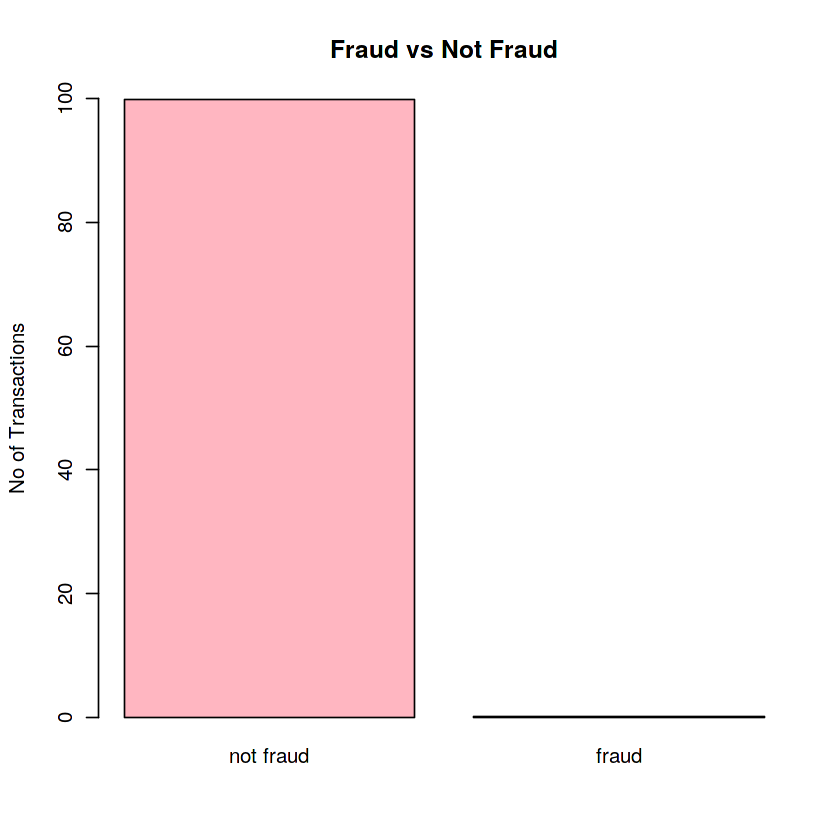

In [8]:
barplot(prop.table(fraud_count$n)*100, names.arg = c('not fraud' ,  'fraud'), ylab = 'No of Transactions' ,main = "Fraud vs Not Fraud" ,col = 'light pink' , ylim = c(0,100))

 
 
 
 
 
 
 
### Transaction Type Plot


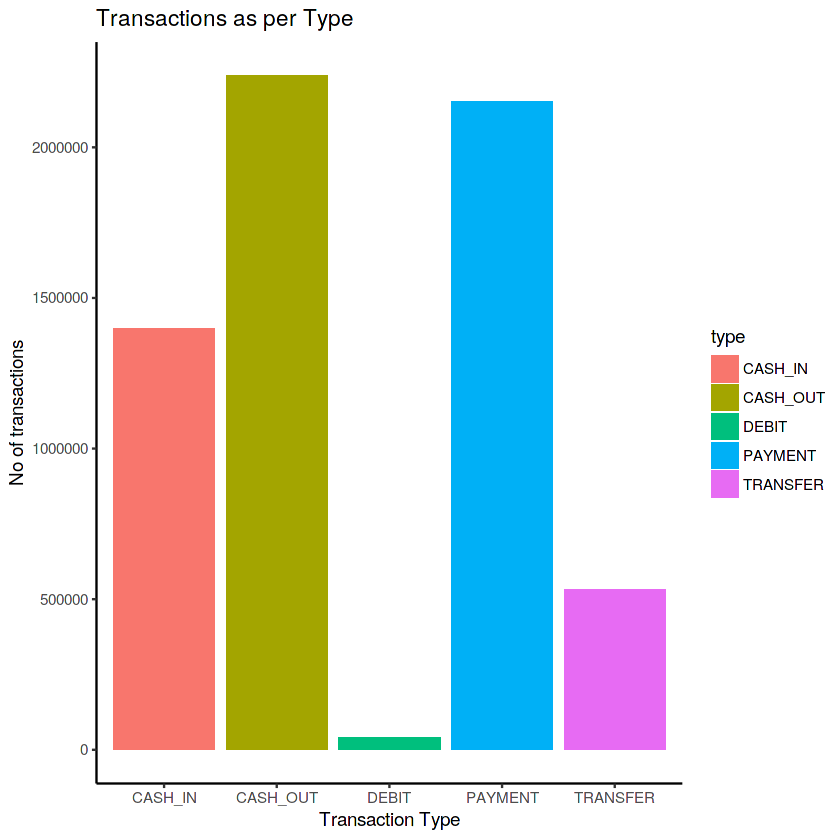

In [9]:
ggplot(data = transactions, aes(x = type , fill = type)) + geom_bar() + labs(title = "Transactions as per Type",  x = 'Transaction Type' , y = 'No of transactions' ) +theme_classic()



### Transaction Types which are more likely to be Fraud

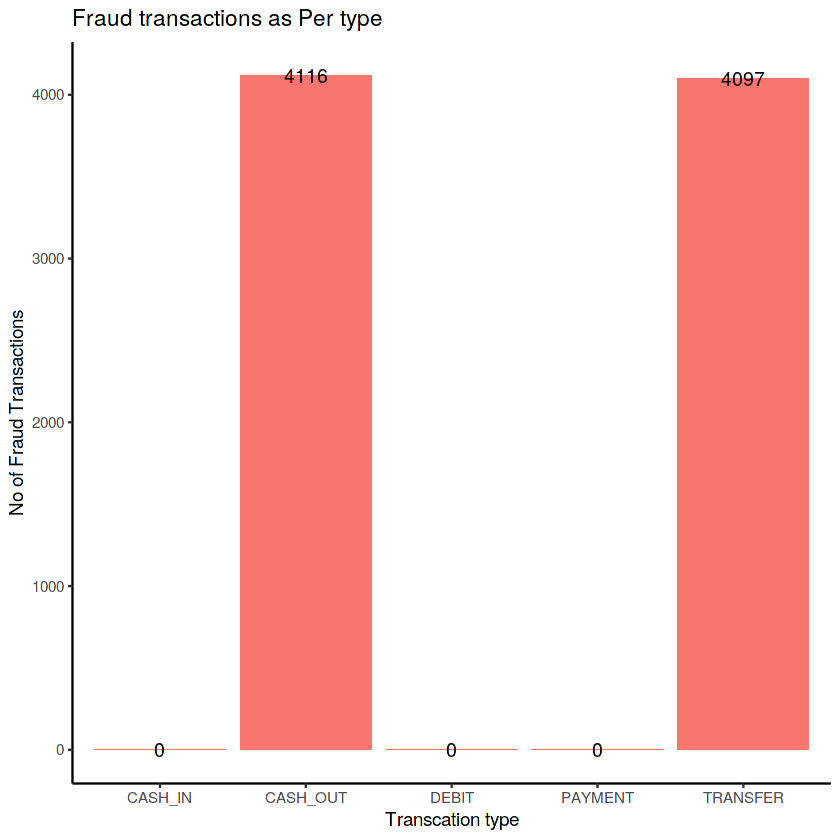

In [10]:
Fraud_trans_type <- transactions %>% group_by(type) %>% summarise(fraud_transactions = sum(isFraud))

ggplot(data = Fraud_trans_type, aes(x = type,  y = fraud_transactions)) + geom_col(aes(fill = 'type'), show.legend = FALSE) + labs(title = 'Fraud transactions as Per type', x = 'Transcation type', y = 'No of Fraud Transactions') + geom_text(aes(label = fraud_transactions), size = 4, hjust = 0.5) + theme_classic()

Its clear from the above plot that all the fraud transactions are either **CASH_OUT** or  ** TRANSFER**  type.

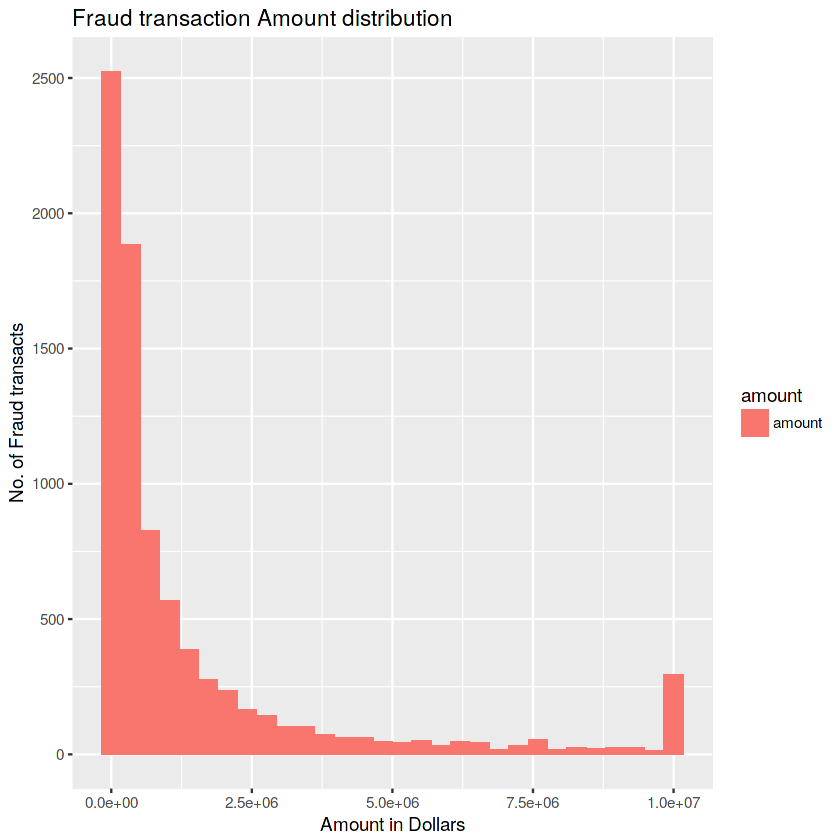

In [11]:
ggplot(data = transactions[transactions$isFraud==1,], aes(x = amount ,  fill =amount)) + geom_histogram(bins = 30, aes(fill = 'amount')) + labs(title = 'Fraud transaction Amount distribution', y = 'No. of Fraud transacts', x = 'Amount in Dollars')


The Frequency distribution of Amount of money involved in Fraud transactions is **Positively Skewed** . It is Clear that most of the fraud transactions are of **Lesser** amount.


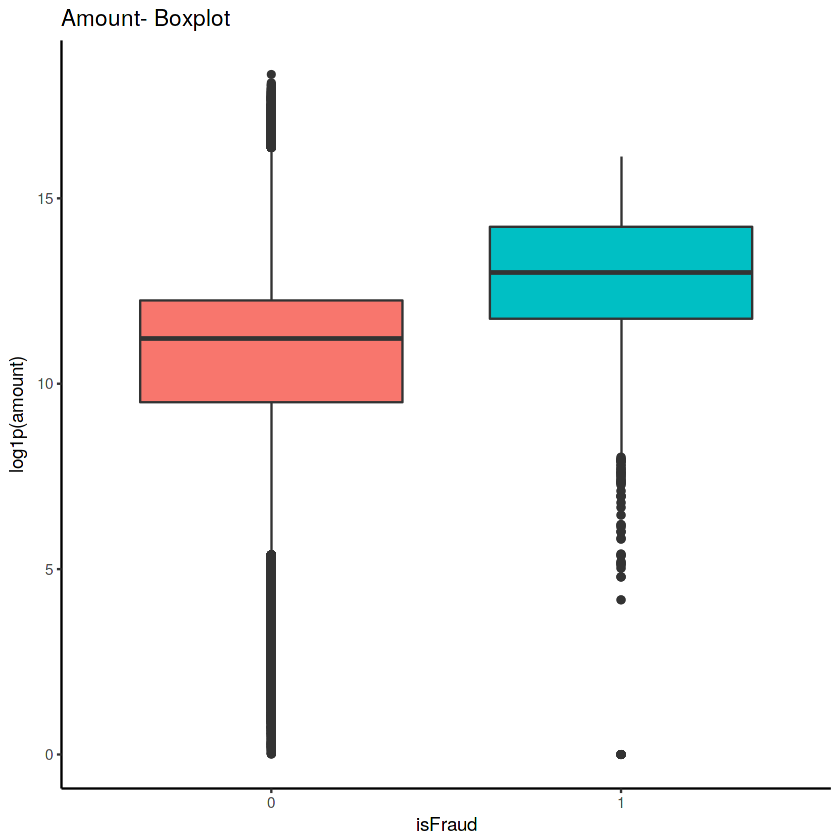

In [12]:
ggplot(data = transactions, aes(x = factor(isFraud) ,y = log1p(amount), fill = factor(isFraud))) + geom_boxplot(show.legend = FALSE) +labs(title= 'Amount- Boxplot' , x = 'isFraud') +  theme_classic()

The above boxplot shows that the *Amount* involved in **fraud** transactions is greater than that of in Non Fraud transactions.

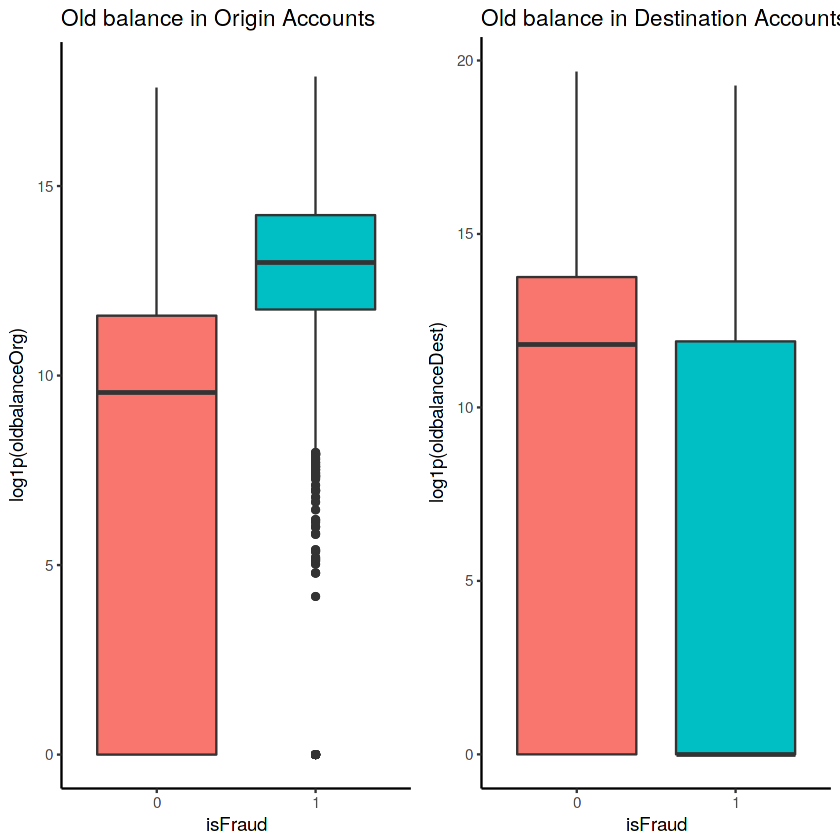

In [13]:
p1<- ggplot(data = transactions, aes(x = factor(isFraud) ,y = log1p(oldbalanceOrg), fill = factor(isFraud))) + geom_boxplot(show.legend = FALSE) +labs(title= 'Old balance in Origin Accounts' , x = 'isFraud') +  theme_classic()

p2 <- ggplot(data = transactions, aes(x = factor(isFraud) ,y = log1p(oldbalanceDest), fill = factor(isFraud))) + geom_boxplot(show.legend = FALSE) +labs(title= 'Old balance in Destination Accounts' , x = 'isFraud') +  theme_classic()

grid.arrange(p1, p2, nrow = 1)

In majority of the fraud transactions the Old balance of the Origin account from which the payments are made is  **higher**  than rest of the origin accounts while the Old balance in Destination accounts is Lower than rest. This is not at all a surprising observation as fraud transactions are made to *  **Steal from the rich and give to the poors.!**  * .

### Distribution of transactions at different time intervals

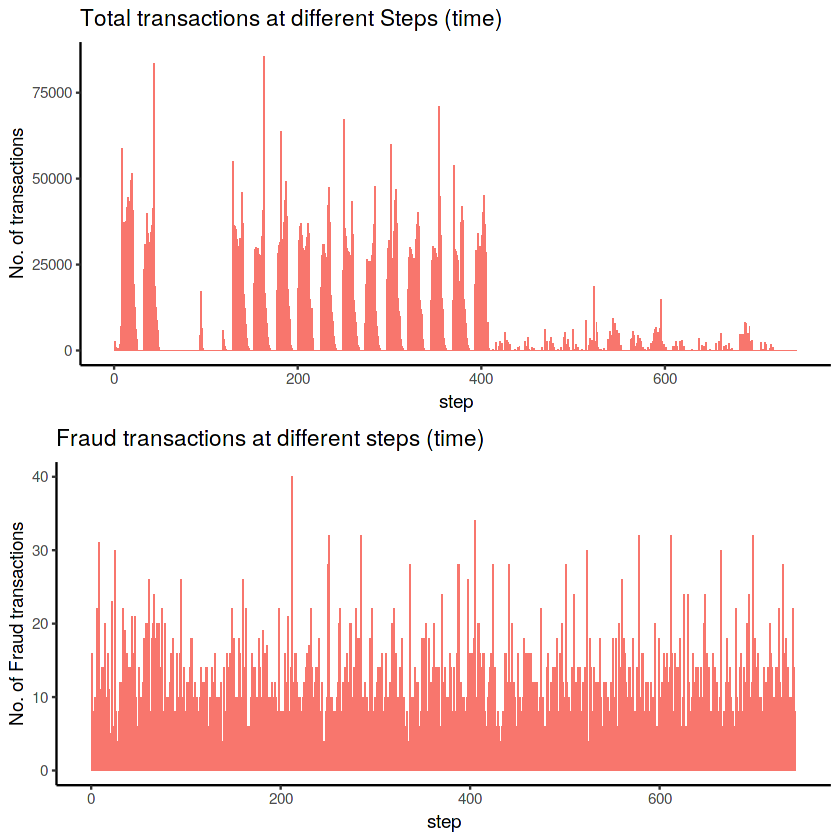

In [14]:
p3<- ggplot(data = transactions, aes(x = step)) + geom_histogram(bins = 700,aes(fill = 'isFraud'), show.legend = FALSE) +labs(title= 'Total transactions at different Steps (time)', y = 'No. of transactions') + theme_classic()

p4<- ggplot(data = transactions[transactions$isFraud==1,], aes(x = step)) + geom_histogram(bins =700, aes(fill = 'isFraud'), show.legend = FALSE) + theme_classic()+ labs(title= 'Fraud transactions at different steps (time)' , y = 'No. of Fraud transactions')

grid.arrange(p3, p4, ncol = 1, nrow = 2)

After **400 step** the total no. of transactions are very **low** but the Fraud transactions doesn't seems to be going down. This looks Surprising. Let's do some more Reasearch here.

### converting Step to Hours in 24 hours format

Each step represents 1 hour of real world and there are total 743 steps for 30 days of data . Lets convert them into 24 hours where each day has 1 to 14 hours and the pattern repeats again


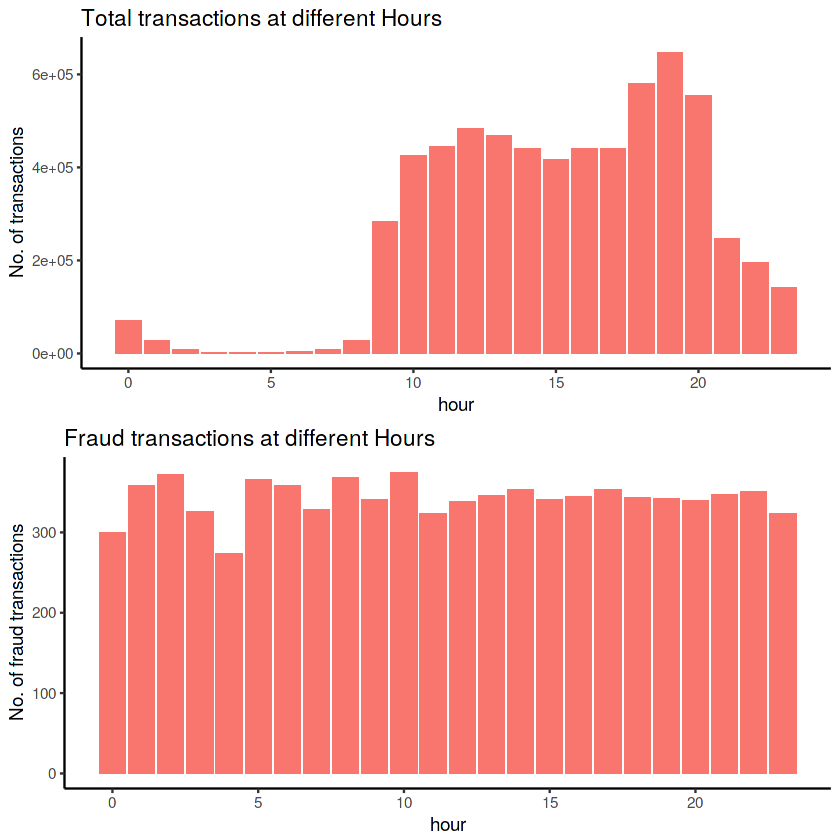

In [15]:
transactions$hour <- mod(transactions$step, 24)

p5<- ggplot(data = transactions, aes(x = hour)) + geom_bar(aes(fill = 'isFraud'), show.legend = FALSE) +labs(title= 'Total transactions at different Hours', y = 'No. of transactions') + theme_classic()

p6<-ggplot(data = transactions[transactions$isFraud==1,], aes(x = hour)) + geom_bar(aes(fill = 'isFraud'), show.legend = FALSE) +labs(title= 'Fraud transactions at different Hours', y = 'No. of fraud transactions') + theme_classic()

grid.arrange(p5, p6, ncol = 1, nrow = 2)

Look at the graphs now, The total no of transactions happening between **0 to 9 hours** are **very low**
 but Farud transactions are still happening at the same rate. Hence it can be concluded that fraud transactions are very often between **0 to 9 hours**.



## Feature Engineering 

Looking closely at the data reveled that there are certain transactions where the transaction Amount is greater than the valancse available in the Origin account.


In [16]:
head(transactions[(transactions$amount > transactions$oldbalanceOrg)& (transactions$newbalanceDest > transactions$oldbalanceDest), c("amount","oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFraud")], 10)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
11,9644.94,4465.00,0,10845,157982.12,0
16,229133.94,15325.00,0,5083,51513.44,0
25,311685.89,10835.00,0,6267,2719172.89,0
49,5346.89,0.00,0,652637,6453430.91,0
73,94253.33,25203.05,0,99773,965870.05,0
82,78766.03,0.00,0,103772,277515.05,0
84,125872.53,0.00,0,348512,3420103.09,0
85,379856.23,0.00,0,900180,19169204.93,0
86,1505626.01,0.00,0,29031,5515763.34,0
89,761507.39,0.00,0,1280036,19169204.93,0


Hence let's create a new feature called **'adjustedBalanceOrg'** and **'adjustedBalanceDest'** where

* **adjustedBalanceOrg** = newbalanceOrg + amount - oldbalanceOrg
* **adjustedBalanceDest** = oldbalanceDest + amount - newbalanceDest


In [17]:
#Creating new features
transactions$adjustedBalanceOrg<-round(transactions$newbalanceOrig+transactions$amount-transactions$oldbalanceOrg, 2)

transactions$adjustedBalanceDest<-round(transactions$oldbalanceDest+transactions$amount-transactions$newbalanceDest, 2)

colnames(transactions)

[1] "step"                "type"                "amount"             
 [4] "nameOrig"            "oldbalanceOrg"       "newbalanceOrig"     
 [7] "nameDest"            "oldbalanceDest"      "newbalanceDest"     
[10] "isFraud"             "isFlaggedFraud"      "hour"               
[13] "adjustedBalanceOrg"  "adjustedBalanceDest"

### Getting Required features

Since all the fraud transactions only occur in CASH_OUT and TRANSFER type, we can only extract those transaction types for modeilling

In [18]:
# Filtering only CASH_OUT and TRANSFER transactions andd droping irrelevant features
transactions1<- transactions %>% 
                select( -one_of('step','nameOrig', 'nameDest', 'isFlaggedFraud')) %>%
                filter(type %in% c('CASH_OUT','TRANSFER'))


### Encoding Dummy variables for transaction type


In [19]:
library(fastDummies)

transactions1 <- dummy_cols(transactions1)

transactions1$isFraud <- as.factor(transactions1$isFraud)
transactions1 <- transactions1[,-1]
colnames(transactions1)

[1] "amount"              "oldbalanceOrg"       "newbalanceOrig"     
 [4] "oldbalanceDest"      "newbalanceDest"      "isFraud"            
 [7] "hour"                "adjustedBalanceOrg"  "adjustedBalanceDest"
[10] "type_TRANSFER"       "type_CASH_OUT"

Now we have one 2 columns **type_TRANSFER** and **type_CASH_OUT** encoded into numeric format.



## Modelling

Let's begin with building a Model to predict the fraud transactions.

### Splitting the train and test set.


In [20]:
set.seed(1)
spl <- sample.split(transactions1$isFraud, 0.8)
transactions_train <- transactions1[spl == TRUE,]
transactions_test <- transactions1[spl == FALSE,]


# Training



## Random Forest

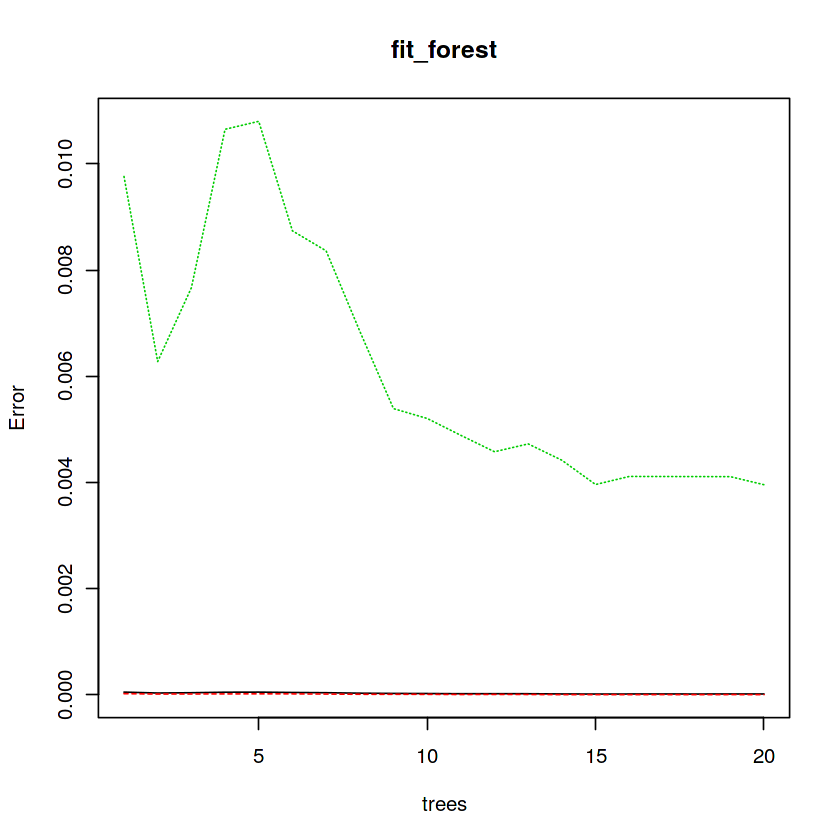

In [21]:
set.seed(1)
fit_forest <- randomForest(isFraud ~ ., data = transactions_train, ntree = 20, mtry = 3)
plot(fit_forest)




### Plotting variable importance

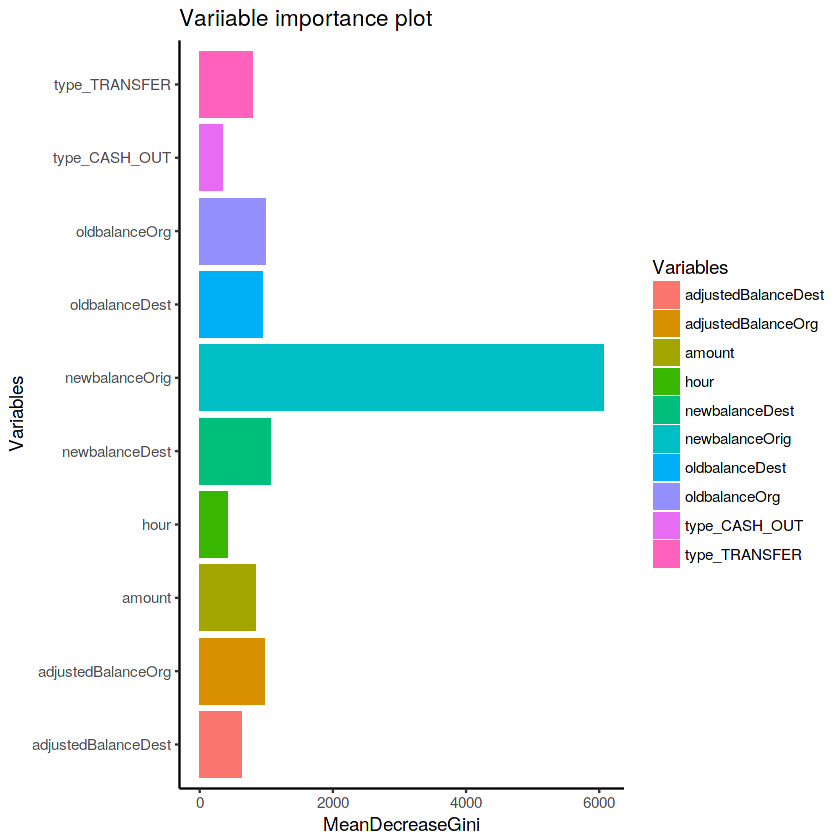

In [22]:
importance_matrix <- data.frame(Variables = rownames(fit_forest$importance), fit_forest$importance, row.names = NULL)

ggplot(data = importance_matrix , aes(y = MeanDecreaseGini , x = Variables, fill = Variables))+ geom_col() + coord_flip() + labs(title= 'Variiable importance plot')+ theme_classic()


### Predicting on test set

In [23]:
pred <- predict(fit_forest, newdata = transactions_test[,-6])

confusion<-confusionMatrix(pred, transactions_test$isFraud )
print(confusion)

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 552439      9
         1      0   1634
                                   
               Accuracy : 1        
                 95% CI : (1, 1)   
    No Information Rate : 0.997    
    P-Value [Acc > NIR] : < 2.2e-16
                                   
                  Kappa : 0.9972   
 Mcnemar's Test P-Value : 0.007661 
                                   
            Sensitivity : 1.0000   
            Specificity : 0.9945   
         Pos Pred Value : 1.0000   
         Neg Pred Value : 1.0000   
             Prevalence : 0.9970   
         Detection Rate : 0.9970   
   Detection Prevalence : 0.9971   
      Balanced Accuracy : 0.9973   
                                   
       'Positive' Class : 0        
                                   


## XGboost

### Converting the data to XGB.Dmatrix format

In [24]:
x_train <- as.matrix(transactions_train[,-6])
y_train <- as.numeric(as.character(transactions_train$isFraud))

x_test <- as.matrix((transactions_test[,-6]))
y_test <- as.numeric(as.character(transactions_test$isFraud))


train_xg<- xgb.DMatrix(data = x_train, label = y_train)
test_xg <- xgb.DMatrix(data = x_test, label = y_test)


### Training XGboost

### XGboost cross validation

In [25]:

#Parameter Grid
param = list(booster = "gbtree", max_depth = 2, eval_metric = 'error',  objective = "binary:logistic")

set.seed(1)

xgb_cv <- xgb.cv(params = param, data = train_xg, nrounds = 20, nfold = 10, metrics = 'error')


[1]	train-error:0.002193+0.000013	test-error:0.002199+0.000081 
[2]	train-error:0.002106+0.000010	test-error:0.002108+0.000084 
[3]	train-error:0.002099+0.000014	test-error:0.002105+0.000083 
[4]	train-error:0.001142+0.000012	test-error:0.001146+0.000053 
[5]	train-error:0.001141+0.000012	test-error:0.001147+0.000052 
[6]	train-error:0.001142+0.000012	test-error:0.001147+0.000052 
[7]	train-error:0.001036+0.000025	test-error:0.001040+0.000058 
[8]	train-error:0.001007+0.000014	test-error:0.001007+0.000050 
[9]	train-error:0.000211+0.000303	test-error:0.000219+0.000320 
[10]	train-error:0.000206+0.000295	test-error:0.000211+0.000308 
[11]	train-error:0.000022+0.000020	test-error:0.000026+0.000025 
[12]	train-error:0.000029+0.000022	test-error:0.000036+0.000030 
[13]	train-error:0.000019+0.000015	test-error:0.000023+0.000025 
[14]	train-error:0.000023+0.000016	test-error:0.000028+0.000028 
[15]	train-error:0.000026+0.000021	test-error:0.000032+0.000028 
[16]	train-error:0.000019+0.000015


### Train and Validation Errors plot for 20 Rounds


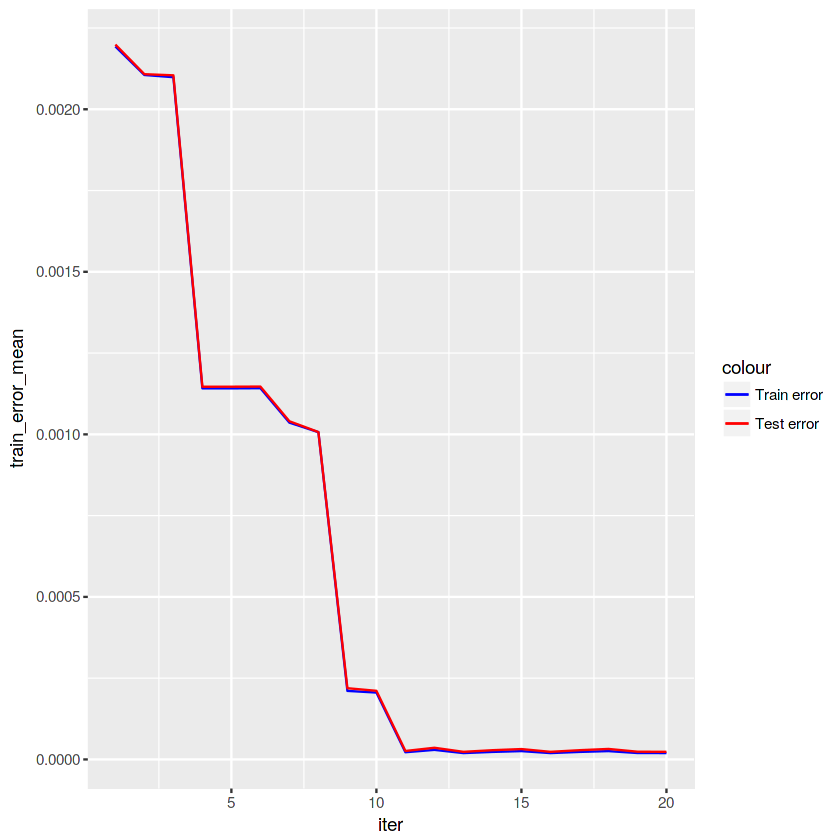

In [26]:
xgb_cv$evaluation_log %>% ggplot(aes(x = iter ,y = train_error_mean, colour = 'blue')) + geom_line() + geom_line(aes(y= test_error_mean , colour = 'red')) + scale_color_manual(labels = c("Train error", "Test error"), values = c('blue', 'red')) 

The optimal no. of rounds given by the xgboost seems to be 11 Rounds where the error on both **train** and **validation set** is minimum, also the model **doesn't** seems to be **overfitting**, as both the train and validation error follows the **same trend**.


## Fitting the final model with watchlist for train and test set.

lets fit the XGboost model with a watchlist for train and test set which will also output the train and test set errors. 


In [27]:
param = list(booster = "gbtree", max_depth = 2 ,eval_metric = 'error',  objective = "binary:logistic")
set.seed(1)
fit <- xgb.train(data = train_xg, params = param, nrounds = 11 , watchlist = list(test_set = test_xg, train_set = train_xg))

[1]	test_set-error:0.002220	train_set-error:0.002185 
[2]	test_set-error:0.002128	train_set-error:0.002101 
[3]	test_set-error:0.002128	train_set-error:0.002101 
[4]	test_set-error:0.001238	train_set-error:0.001144 
[5]	test_set-error:0.001240	train_set-error:0.001144 
[6]	test_set-error:0.001240	train_set-error:0.001145 
[7]	test_set-error:0.001105	train_set-error:0.001026 
[8]	test_set-error:0.001052	train_set-error:0.000997 
[9]	test_set-error:0.000016	train_set-error:0.000012 
[10]	test_set-error:0.000016	train_set-error:0.000012 
[11]	test_set-error:0.000016	train_set-error:0.000012 



# Train and Test set error plot

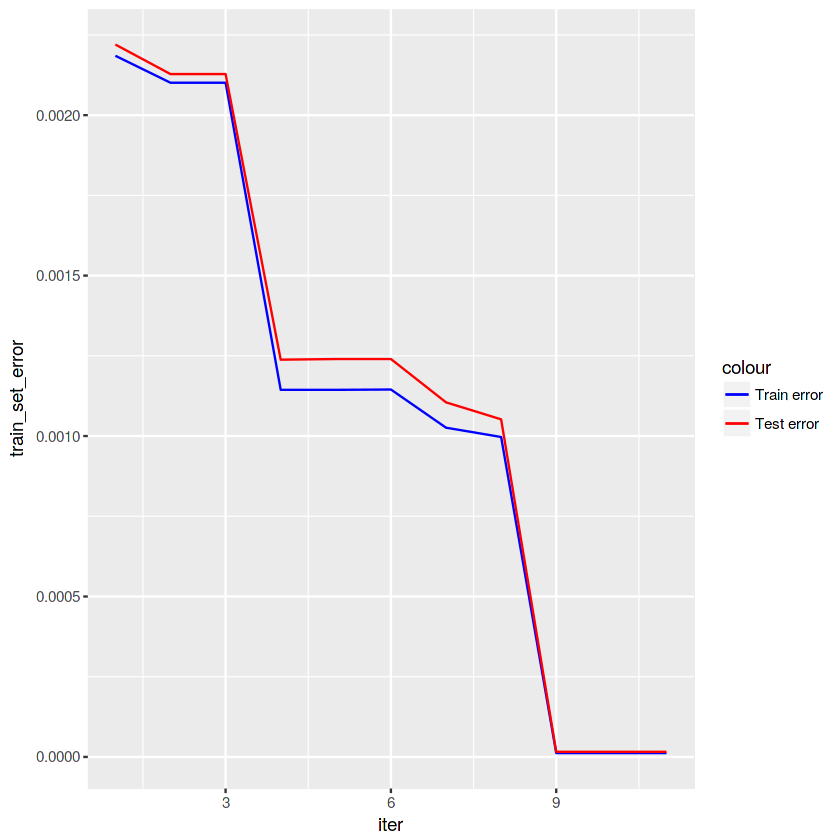

In [28]:
fit$evaluation_log %>% ggplot(aes(x = iter ,y = train_set_error, colour = 'blue')) + geom_line() +geom_line(aes(y= test_set_error , colour = 'red')) + scale_color_manual(labels = c("Train error", "Test error"), values = c('blue', 'red'))


seems like the the error is highly **minimized** **without any Overfitting**. as the Test set on which the model is not trained is also giving the same error as the train set. Hope the accuracy will also be same for both train and test sets.



## Confusion Matrix

In [29]:
pred_xgb <- predict(fit,newdata = test_xg)
pred_class<- ifelse(pred_xgb>0.5,1,0)

confusionMatrix(pred_class, y_test)

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 552439      9
         1      0   1634
                                   
               Accuracy : 1        
                 95% CI : (1, 1)   
    No Information Rate : 0.997    
    P-Value [Acc > NIR] : < 2.2e-16
                                   
                  Kappa : 0.9972   
 Mcnemar's Test P-Value : 0.007661 
                                   
            Sensitivity : 1.0000   
            Specificity : 0.9945   
         Pos Pred Value : 1.0000   
         Neg Pred Value : 1.0000   
             Prevalence : 0.9970   
         Detection Rate : 0.9970   
   Detection Prevalence : 0.9971   
      Balanced Accuracy : 0.9973   
                                   
       'Positive' Class : 0        
                                   

**Hurrey!!!**, the **confusion matrix** of the test set looks very impressive. The **TRUE POSITIVE** rate is **100%** while there are only 9 **FALSE POSITIVES** (Positive class being '0').

** ACCURACY ** = **0.9973**


### XGB variable Importance Plot

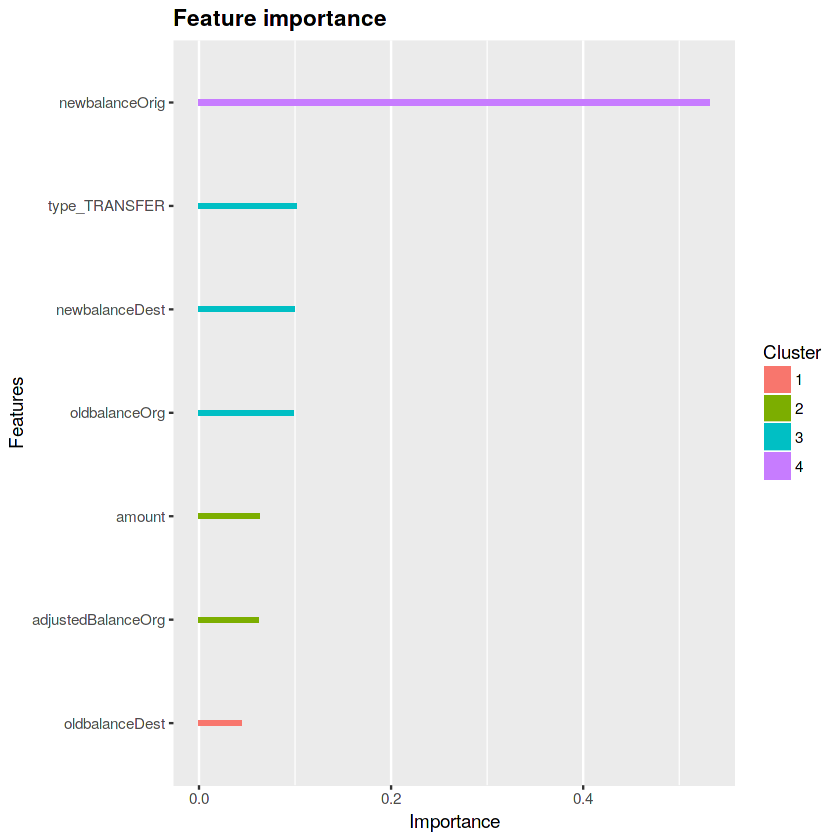

In [30]:
xgb_importance <- xgb.importance(feature_names = names(transactions_train[,-6]) , model = fit)

xgb.ggplot.importance(xgb_importance)